### Import Modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import struct 
from tabulate import tabulate

%matplotlib inline

from gensim.models.word2vec import Word2Vec

from collections import Counter, defaultdict

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.ensemble import ExtraTreesClassifier, \
RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cross_validation import cross_val_score, train_test_split, StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I want to see whether word embeddings can improve text classification accuracy.  Word embeddings map semantic meaning into a geometric space.  This means that they associate a numeric vector to every word in a dictionary. The distance between any two vectors captures part of the semantic relationshup between the two associated words.  I am using a 300-dimensional GloVe embedding of 400k words computed on a 2014 dump of English Wikipedia.  I think training my models on this pretrained word embedding will yield good results because it represents a larger vector space than my original dataset. 

In this notebook, I compute a document embedding by taking the component-wise mean of its component word embeddings. This method for implementing a pre-trained word embedding was motivated by [this blog post on text classification](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/).

### Import Clean DataFrame

In [2]:
with open('../Data/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

In [3]:
df_train.shape

(24904, 4)

### Import Stop Words List

In [4]:
with open('../Data/stop_word_list.pkl', 'rb') as f:
    stop_word_list = pickle.load(f)

### Import Pre-trained Word Embedding

In [5]:
GLOVE_6B_300D_PATH = "../Pretrained_Models//glove.6B/glove.6B.300d.txt"
encoding= "utf-8"

# GloVe Word Embedding 

Prepare word embedding by loading it into python.

In [6]:
with open(GLOVE_6B_300D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

Create a generator to confirm that the embedding is set up properly.  This generator will iterate through each word and its associated vector within the GloVe word embedding.

In [7]:
def gen(wvec):
    for k,v in wvec.items():
        yield k,v

item = gen(wvec)

In [8]:
# next(item)

Replace the 'neg' and 'pos' labels in my dataframe with 1s and 0s in preparation for modeling.

In [9]:
df_train.replace({'pos': 1, 'neg': 0}, inplace=True)

In [10]:
X = df_train.review.map(lambda x: x.split()).tolist()
X = df_train.review.tolist()
y = df_train.label.tolist()

In [11]:
X_words = [y.split() for y in X]

This reads the glove files line by line and only saves vectors that correspond to words from my original data set.

In [12]:
glove = {}
all_words = set(w for words in X_words for w in words)
with open(GLOVE_6B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove[word] = nums

In [13]:
print(len(all_words))

73241


In [14]:
# model = Word2Vec(X_words, size=100, window=5, min_count=5, workers=2)
# w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

# Benchmark Modeling

I will now benchmark a number of different models (without fitting to training data) to get a sense of which models perform best before choosing one to further tune parameters.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

### Export X_train and X_test

In [16]:
with open('../Data/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
    
with open('../Data/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

### Export y_train and y_test

In [17]:
with open('../Data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
    
with open('../Data/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

I will first run a number of simple classifiers with either pure counts or tfidf features.

In [18]:
bern_nb = Pipeline([("count_vectorizer", CountVectorizer()),
                    ("bernoulli nb", BernoulliNB())])
lr = Pipeline([("count_vectorizer", CountVectorizer()),
                ("lr", LogisticRegression())])
rf = Pipeline([("count_vectorizer", CountVectorizer()),
                ("rf", RandomForestClassifier(n_estimators=200))])

et = Pipeline([("count_vectorizer", CountVectorizer()),
                ("et", ExtraTreesClassifier(n_estimators=200))])

gb = Pipeline([("count_vectorizer", CountVectorizer()),
                ("gb", GradientBoostingClassifier(n_estimators=200))])

bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),
                          ("bernoulli nb", BernoulliNB())])
lr_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),
                      ("lr", LogisticRegression())])
rf_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),
                ("rf", RandomForestClassifier(n_estimators=200))])
et_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),
                ("et", ExtraTreesClassifier(n_estimators=200))])
gb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),
                ("gb", GradientBoostingClassifier(n_estimators=200))])

The following two classes act as a method by which to build features. They do this by averaging word vectors for all words in a text and they contain a transformer that is initialized with a word to vector dictionary.  The first class takes an average of all of the word vectors.  The second class does the same, but also incroporates a term frequency inverse term document frequency vectorizer, so the words will be weighted differently as opposed to just a simple average.

In [19]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove))])
        else:
            self.dim=0
            
    def fit(self, X_train, y_train):
        return self 

    def transform(self, X_train):
        X_train = [y.split() for y in X_train]
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X_train
        ])

In [20]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove))])
        else:
            self.dim=0
        
    def fit(self, X_train, y_train):
        X_train = [y.split() for y in X_train]
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X_train)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X_train):
        X_train = [y.split() for y in X_train]
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X_train
            ])

In [21]:
bern_nb_glove = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove)), 
                          ("bernoulli nb", BernoulliNB())])
lr_glove = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove)), 
                      ("lr", LogisticRegression())])
rf_glove = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove)), 
                     ("random forest", RandomForestClassifier(n_estimators=200))])
et_glove = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove)), 
                     ("extra trees", ExtraTreesClassifier(n_estimators=200))])
gb_glove = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove)),
                     ("gb", GradientBoostingClassifier())])

## Add NN it to the pipline 

### Benchmark Scores

In [22]:
%%time

all_models = [
    ("bern_nb", bern_nb),
    ("lr", lr),
    ("rf", rf),
    ("et", et),
    ("gb", gb),
    
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("lr_tfidf", lr_tfidf),
    ("rf_tfidf", rf_tfidf),
    ("et_tfidf", et_tfidf),
    ("gb_tfidf", gb_tfidf),
    
   ("bern_nb_glove", bern_nb_glove),
    ("lr_glove", lr_glove),
    ("rf_glove", rf_glove),
    ("et_glove", et_glove),
   ("gb_glove", gb_glove)
]

unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])  
benchmark_df = pd.DataFrame(scores, columns=['model', 'score'])
print(benchmark_df)

            model     score
0        lr_tfidf  0.874666
1              et  0.867813
2              lr  0.866207
3        et_tfidf  0.857105
4         bern_nb  0.848806
5   bern_nb_tfidf  0.848806
6              rf  0.845005
7        rf_tfidf  0.834940
8        lr_glove  0.833976
9              gb  0.831620
10       gb_tfidf  0.827658
11       gb_glove  0.801532
12       rf_glove  0.780866
13       et_glove  0.780598
14  bern_nb_glove  0.699112
CPU times: user 14min 27s, sys: 13.3 s, total: 14min 41s
Wall time: 16min 8s


### Plot Benchmarks

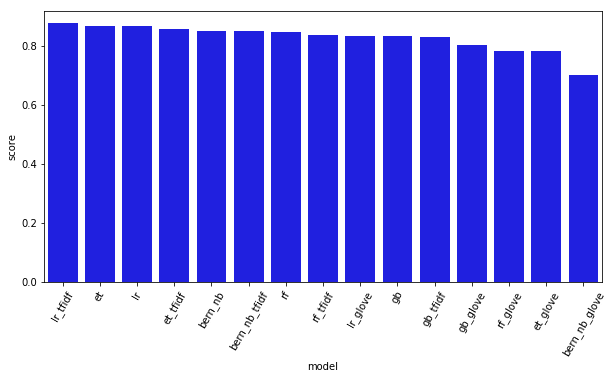

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(x= benchmark_df['model'], y= benchmark_df['score'], color='blue')

plt.xticks(rotation = 60);

# Modeling with TFIDF

Seeing as the logistic regression model with a tfidf vectorizer benchmark scored the best I will go ahead and try to tune some of the parameters.

In [24]:
%%time

np.random.seed(41)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_word_list)),
    ('lr', LogisticRegression())
])

params = {
    'tfidf__max_df': [0.7],
    'tfidf__min_df': [2]
}

gs_tfidf = GridSearchCV(pipe, param_grid = params)
gs_tfidf.fit(X_train, y_train);

CPU times: user 22.2 s, sys: 552 ms, total: 22.7 s
Wall time: 26.4 s


In [25]:
gs_tfidf.best_score_

0.8798051183210194

In [26]:
gs_tfidf.score(X_train, y_train), gs_tfidf.score(X_test, y_test)

(0.9377342327872363, 0.8882107292001284)

In [27]:
gs_tfidf.best_params_

{'tfidf__max_df': 0.7, 'tfidf__min_df': 2}

### Export TFIDF

In [28]:
with open('../Data/tfidf.pkl', 'wb+') as f:
    pickle.dump(gs_tfidf, f)

### Confusion matrix for TFIDF

In [29]:
y_pred = gs_tfidf.best_estimator_.predict(X_test)

In [30]:
confusion_matrix(y_test, y_pred)

array([[2703,  410],
       [ 286, 2827]])

True Negatives: 2703
False Positives: 410
False Negatives: 286
True Positives: 2827
             precision    recall  f1-score   support

          0       0.90      0.87      0.89      3113
          1       0.87      0.91      0.89      3113

avg / total       0.89      0.89      0.89      6226



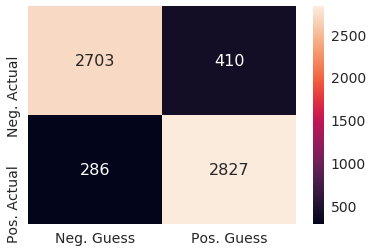

In [31]:
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g',
           yticklabels = ['Neg. Actual', 'Pos. Actual'],
           xticklabels = ['Neg. Guess', 'Pos. Guess'],
           annot_kws={"size": 16},)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print(classification_report(y_test,y_pred))

### EDA with TFIDF

In [32]:
tfidf_features = pd.DataFrame(data=gs_tfidf.best_estimator_.named_steps.tfidf.transform(X_test).toarray(),
             columns=gs_tfidf.best_estimator_.named_steps.tfidf.get_feature_names())
len(tfidf_features.columns)

38989

In [33]:
tfidf_features.insert(0, 'Sentiment', y_test)

In [34]:
tfidf_positive_top_20 = tfidf_features.groupby('Sentiment').sum().T.sort_values(1, ascending=False).head(20)
tfidf_negative_top_20 = tfidf_features.groupby('Sentiment').sum().T.sort_values(0, ascending=False).head(20)

#mean of sentiment - words that show up more frequently might get unfair advantage.

In [35]:
top_20_pos = pd.DataFrame(tfidf_positive_top_20)
top_20_pos.rename(columns={0: 'negative', 1: 'positive'}, inplace=True)

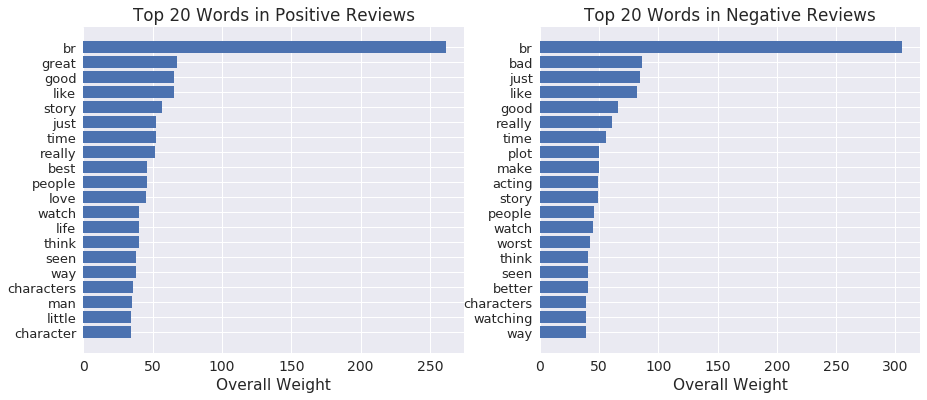

In [36]:
x = range(20)
fig = plt.figure(figsize=(15,6))

fig.add_subplot(121)

plt.barh(x, tfidf_positive_top_20[1][::-1])
plt.yticks(x[::-1], tfidf_positive_top_20.index, rotation=0, fontsize=13)
plt.title('Top 20 Words in Positive Reviews')
plt.xlabel('Overall Weight')

fig.add_subplot(122)

plt.barh(x, tfidf_negative_top_20[0][::-1])
plt.yticks(x[::-1], tfidf_negative_top_20.index, rotation=0, fontsize=13)
plt.title('Top 20 Words in Negative Reviews')
plt.xlabel('Overall Weight');

# list of words (word map)